# Broad Institute Project

## Goals
- Generate a PCA value table for each sample from the call set
- Classify samples with missing ancestry labels
- Visualize PC values for each sample w/ labels for known and predicted classifications

### Initial Filtering
- high callrate (95%)
- bi-allelic only (no haplotypes)
- common alleles (allele freq. > 0.01)
- linkage disequilibrium pruned to r2 < 0.1 (allelic independence)
- normalize genotypes after filtering

In [3]:
# import libraries
import os
import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')

# hail packages
import hail as hl
hl.init(min_block_size=128)
from hail.plot import show
from pprint import pprint
import bokeh
from bokeh.io import output_notebook, show
hl.plot.output_notebook()

2022-04-06 13:26:06 WARN  Utils:69 - Your hostname, Jakes-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
2022-04-06 13:26:06 WARN  Utils:69 - Set SPARK_LOCAL_IP if you need to bind to another address


2022-04-06 13:26:07 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-04-06 13:26:07 WARN  Hail:43 - This Hail JAR was compiled for Spark 3.1.2, running with Spark 3.1.3.
  Compatibility is not guaranteed.


Running on Apache Spark version 3.1.3
SparkUI available at http://192.168.0.12:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.91-44b441376f9a
LOGGING: writing to /Users/jakeharris/Desktop/BroadProject/hail-20220406-1326-0.2.91-44b441376f9a.log


Loading BokehJS ...

In [4]:
# Set working directory
print('Current wd:', os.getcwd())
desktop_dir = os.path.join('/Users', 'jakeharris', 'Desktop', 'BroadProject')
os.chdir(desktop_dir)
print('New wd:', os.getcwd())

Current wd: /Users/jakeharris/Desktop/BroadProject
New wd: /Users/jakeharris/Desktop/BroadProject


In [3]:
# Run initial filter w/ VCFtools 
    ## minor allele freq. >0.01
    ## bi-allelic only
    ## quality score >5
    ## max. allowable missing data < 0.1
!vcftools --gzvcf acs_mini_project.vcf.bgz --max-missing 0.9 --maf 0.01 --min-alleles 2 --max-alleles 2 \
--minQ 5 --recode --recode-INFO-all --out initial-vcf-filter


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf acs_mini_project.vcf.bgz
	--recode-INFO-all
	--maf 0.01
	--max-alleles 2
	--min-alleles 2
	--minQ 5
	--max-missing 0.9
	--out initial-vcf-filter
	--recode

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting VCF file...
After filtering, kept 92402 out of a possible 2203614 Sites
Run Time = 396.00 seconds


In [4]:
# LD variant pruning for r2 < 0.1
    ## window size 50 
    ## step size 5 variant ct
    ## r2 threshold < 0.1
!plink --vcf initial-vcf-filter.recode.vcf --indep-pairwise 50 5 0.1
!plink --vcf initial-vcf-filter.recode.vcf --extract plink.prune.in --make-bed --out pruned-plink2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --indep-pairwise 50 5 0.1
  --vcf initial-vcf-filter.recode.vcf

8192 MB RAM detected; reserving 4096 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
92402 variants loaded from .bim file.
1966 people (0 males, 0 females, 1966 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1966 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.993399.
92402 variants and 1966 people pass filters and QC.
Note: No phen

In [4]:
# import Plink table to hail
hl.import_plink(bed='pruned-plink2.bed',
                bim='pruned-plink2.bim',
                fam='pruned-plink2.fam').write('BroadProject-plink2.mt', overwrite=True)

mt = hl.read_matrix_table('BroadProject-plink2.mt')
mt.describe()
mt.GT.show(5)  # first 5 genotype entries
mt.aggregate_entries(hl.agg.counter(mt.GT.n_alt_alleles()))  # count alt_alleles in GT

2022-04-06 13:26:17 Hail: INFO: Found 1966 samples in fam file.
2022-04-06 13:26:17 Hail: INFO: Found 41616 variants in bim file.
2022-04-06 13:26:28 Hail: INFO: wrote matrix table with 41616 rows and 1966 columns in 2 partitions to BroadProject-plink2.mt


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


,,,,,
,,'1','2','3','4'
locus,alleles,GT,GT,GT,GT
locus<GRCh37>,array<str>,call,call,call,call
1:894573,"[""A"",""G""]",0/0,0/1,1/1,0/1
1:898323,"[""C"",""T""]",0/0,0/0,0/0,0/0
1:898852,"[""C"",""T""]",0/0,0/0,0/0,0/0
1:908275,"[""G"",""A""]",0/0,0/0,0/0,0/0
1:908749,"[""C"",""T""]",0/0,0/0,0/0,0/0


frozendict({0: 67233428, 1: 11148119, 2: 2832868, None: 602641})

In [5]:
# edit sample_id labels in ancestry.txt file 
anc_df = pd.read_csv('acs_mini_project_labels.txt', header=0, sep='\t')
for i in range(len(anc_df['sample_id'])):
    anc_df['sample_id'][i] = str(anc_df['sample_id'][i].split('_')[1])  # remove 'TGG_'
anc_df.to_csv('ancestry_labels_edit.tsv', header=True, index=None, sep='\t', na_rep='NA')

# import ancestry labels .txt file as Hail table & join w/ MatrixTable
anc_table = hl.import_table('ancestry_labels_edit.tsv',
                            key='sample_id',
                            types={'sample_id': hl.tstr, 'ancestry': hl.tstr})
mt = mt.annotate_cols(anc = anc_table[mt.s].ancestry)  # join ancestry labels to mt
mt.anc.show(5)  
pprint(mt.aggregate_cols(hl.agg.counter(mt.anc)))  # count ancestry labels

2022-04-06 13:26:33 Hail: INFO: Reading table without type imputation
  Loading field 'sample_id' as type str (user-supplied)
  Loading field 'ancestry' as type str (user-supplied)


,
s,anc
str,str
"""1""",NA
"""2""",NA
"""3""","""eas"""
"""4""",NA
"""5""","""eas"""


frozendict({'afr': 382, 'amr': 155, 'eas': 253, 'fin': 58, 'nfe': 210, 'sas': 228, None: 680})


In [6]:
# further QC filters to MatrixTable
mt = hl.sample_qc(mt, name='sample_qc')
mt = hl.variant_qc(mt, name='variant_qc')
mt = mt.filter_cols(mt.sample_qc.call_rate >= 0.95)  # callrate >95%
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.01)  # variants w/ allele freq. >0.01
mt.GT.summarize()  # most missing GTs are filtered 

Non-missing,81085755 (99.26%)
Missing,601545 (0.74%)
Homozygous Reference,67106816
Heterozygous,11146395
Homozygous Variant,2832544
Ploidy,frozendict({2: 81085755})
Phased,frozendict({False: 81085755})


### PCA

In [7]:
# run Hardy-Weinberg normalized PCA on mt.GT (PCs=10) to reduce dimensionality 
pca_eigen, pca_scores, _ = hl.hwe_normalized_pca(mt.GT)
pprint(pca_eigen)
pca_scores.show(5)
cumulative_pred = [sum(pca_eigen[0:i])/sum(pca_eigen) for i in range(1,11)]

2022-04-06 13:26:50 Hail: INFO: hwe_normalize: found 41550 variants after filtering out monomorphic sites.
2022-04-06 13:26:53 Hail: INFO: pca: running PCA with 10 components... + 2) / 2]


[122.04221312954746,
 47.0634740395591,
 27.502106042250052,
 14.368862825633087,
 11.301665907494064,
 9.499574336481622,
 6.523390529389579,
 5.492829804171036,
 4.160724102151552,
 3.803874125837476]


,
s,scores
str,array<float64>
"""1""","[-1.09e-01,1.86e-01,3.79e-03,4.09e-02,7.29e-03,5.93e-02,-5.11e-02,2.15e-02,-4.27e-03,2.38e-02]"
"""10""","[-1.36e-01,2.19e-01,2.42e-02,2.07e-02,1.53e-02,1.01e-01,-1.37e-02,1.59e-02,-2.60e-03,-3.13e-02]"
"""100""","[-1.36e-01,1.90e-01,5.92e-03,2.36e-02,2.58e-02,8.97e-02,-3.21e-03,1.20e-02,-3.39e-02,1.86e-02]"
"""1000""","[4.46e-01,-4.82e-02,1.15e-02,-9.48e-03,-4.91e-02,2.10e-02,-6.49e-03,-5.37e-02,-4.75e-02,-1.11e-01]"
"""1001""","[4.45e-01,-2.58e-02,-6.62e-03,2.64e-03,-1.06e-02,1.91e-02,2.66e-02,-1.06e-02,-8.27e-02,-8.12e-02]"


[]

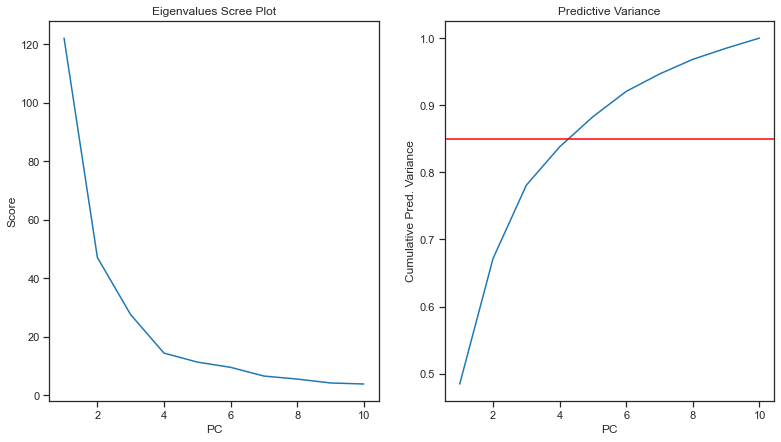

In [8]:
# visualize for choosing num. of PCs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,7))
# scree plot
ax1.plot(range(1,11), pca_eigen)
ax1.set(xlabel='PC', ylabel='Score')
ax1.set_title('Eigenvalues Scree Plot')  # ~elbows at PC 4
ax1.plot()
# cumulative predictive variance
ax2.plot(range(1,11), cumulative_pred)
ax2.axhline(0.85, c='r')  # ~85% pred. variance at PC 4
ax2.set(xlabel='PC', ylabel='Cumulative Pred. Variance')
ax2.set_title('Predictive Variance')
ax2.plot()

In [9]:
# convert PCA scores Table to pandas DF
scores_df = pca_scores.annotate(anc = anc_table[pca_scores.s].ancestry)  # add ancestry labels
scores_df = scores_df.to_pandas()
scores_df['s'] = pd.to_numeric(scores_df['s'])
scores_df = scores_df.sort_values(by=['s']).reset_index(drop=True)
scores_df = scores_df.rename(columns={'s':'sample_id', 'anc':'ancestry'})

# split PCA scores lists into individual cols, join w/ scores_df
pc_cols = [f'PC{x}' for x in range(1,11)]
pca_df = pd.DataFrame(scores_df['scores'].tolist(), columns=pc_cols)
df = pd.concat([scores_df, pca_df], axis=1).drop('scores', axis=1)
df.head()

2022-04-06 13:28:22 Hail: INFO: Ordering unsorted dataset with network shuffle
2022-04-06 13:28:22 Hail: INFO: Ordering unsorted dataset with network shuffle


,sample_id,ancestry,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,<NA>,-0.108950,0.185796,0.003794,0.040872,0.007293,0.059343,-0.051051,0.021510,-0.004269,0.023797
1,2,<NA>,-0.099430,0.167728,-0.008247,0.049278,-0.003240,0.037837,-0.047196,0.011902,-0.005860,0.026438
2,3,eas,-0.162769,-0.180516,-0.166356,0.031430,0.077520,0.051509,-0.060998,0.021161,0.007530,0.017163
3,4,<NA>,-0.164679,-0.174732,-0.161684,0.037865,0.070457,0.052421,-0.063559,0.009929,0.020001,0.000998
4,5,eas,-0.162195,-0.183088,-0.167374,0.045454,0.086184,0.049309,-0.054672,0.003709,0.012089,0.014168


### Classification

- Supervised machine learning based on known ancestry labels and PCA values
- K Nearest Neighbor algorithm 
    - relatively simple
    - label unknown samples based on distance in PCA dimensions
    - more accurate than Decision Tree
    - works with multiclass unlike SVM
    - consider other methods if using larger dataset due to computational burden


In [10]:
# classification of unknown ancestry labels using KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split df based on known/unknown ancestry
known_df = df[~df['ancestry'].isna()]
known_df['predicted'] = False  # col. indicating anc. labels are already known
nan_df = df[df['ancestry'].isna()]
nan_df['predicted'] = True

# create instance of LabelEncoder to make numeric labels for ancestry
le = preprocessing.LabelEncoder()
anc_le = le.fit_transform(known_df['ancestry'])  # 6 anc. labels
lab = le.inverse_transform(anc_le)

# create features list of PCs 1-4
pc_features = list(zip(known_df['PC1'], known_df['PC2'], known_df['PC3'], known_df['PC4']))
pprint(pc_features[:3])

[(-0.16276923591903478,
  -0.18051633198345443,
  -0.16635592774861477,
  0.03143020705319569),
 (-0.16219522188037347,
  -0.18308768876730674,
  -0.1673736731102984,
  0.04545390510526709),
 (-0.13615261077238494,
  0.22742118703088465,
  0.022659940859158748,
  0.012263961985858836)]


/var/folders/3v/3dcdttlj2xdgr3jcgn0mdt040000gn/T/ipykernel_1441/3704569124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_df['predicted'] = False  # col. indicating anc. labels are already known
/var/folders/3v/3dcdttlj2xdgr3jcgn0mdt040000gn/T/ipykernel_1441/3704569124.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_df['predicted'] = True


{1: 0.9883720930232558,
 2: 0.9883720930232558,
 3: 0.9844961240310077,
 4: 0.9806201550387597,
 5: 0.9767441860465116,
 6: 0.9806201550387597,
 7: 0.9767441860465116,
 8: 0.9806201550387597,
 9: 0.9767441860465116,
 10: 0.9767441860465116,
 11: 0.9728682170542635,
 12: 0.9728682170542635,
 13: 0.9728682170542635,
 14: 0.9728682170542635,
 15: 0.9728682170542635,
 16: 0.9728682170542635,
 17: 0.9728682170542635,
 18: 0.9728682170542635,
 19: 0.9728682170542635,
 20: 0.9728682170542635,
 21: 0.9689922480620154,
 22: 0.9573643410852714,
 23: 0.9573643410852714,
 24: 0.9573643410852714}


Text(0, 0.5, 'Accuracy')

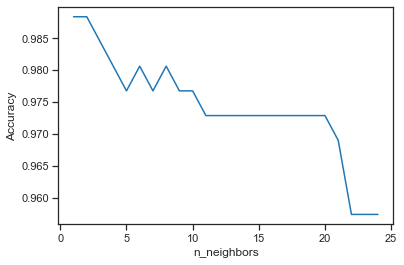

In [11]:
# train/test data for supervised learning (80% train/20% test split)
X_train, X_test, y_train, y_test = train_test_split(pc_features, anc_le, test_size=0.2, random_state=4)

# run multiple KNN classifications to check for optimal n_neighbors
acc_scores = {}
for k in range(1,25):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc_scores[k] = metrics.accuracy_score(y_test, y_pred)
pprint(acc_scores)

# plot of accuracy of k-neighbors -> k=3 is good choice because not even num, high accuracy
plt.plot(range(1,25), acc_scores.values())
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')

In [12]:
# classify unknown ancestry samples in nan_df using kNN model
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
anc_classes = {0: 'afr', 1: 'amr', 2: 'eas', 3: 'fin', 4: 'nfe', 5: 'sas'}
X_unknown = list(zip(nan_df['PC1'], nan_df['PC2'], nan_df['PC3'], nan_df['PC4']))  # PC values
anc_predict = classifier.predict(X_unknown)  # list of pred. anc_class.keys()

# predict ancestries, add to nan_df
anc_list = []
for i in range(len(anc_predict)):
    anc_list.append(anc_classes[anc_predict[i]])
nan_df['ancestry'] = anc_list
nan_df.head()

/var/folders/3v/3dcdttlj2xdgr3jcgn0mdt040000gn/T/ipykernel_1441/2179299177.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_df['ancestry'] = anc_list


,sample_id,ancestry,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,predicted
0,1,amr,-0.108950,0.185796,0.003794,0.040872,0.007293,0.059343,-0.051051,0.021510,-0.004269,0.023797,True
1,2,amr,-0.099430,0.167728,-0.008247,0.049278,-0.003240,0.037837,-0.047196,0.011902,-0.005860,0.026438,True
3,4,eas,-0.164679,-0.174732,-0.161684,0.037865,0.070457,0.052421,-0.063559,0.009929,0.020001,0.000998,True
5,6,nfe,-0.182688,0.153385,0.286218,0.016470,0.214450,-0.178499,-0.067623,0.083320,-0.028691,-0.064241,True
10,11,nfe,-0.133551,0.205124,0.028771,0.019358,0.013979,0.105923,-0.013851,0.002123,0.000936,-0.032794,True


In [13]:
# concat known_df w/ nan_df, save to .csv
final_df = pd.concat([known_df, nan_df])
final_df = final_df.sort_values(by=['sample_id']).reset_index(drop=True)
final_df.to_csv('BroadProject_PCvalues.csv')  # save to .csv
final_df.head()

,sample_id,ancestry,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,predicted
0,1,amr,-0.108950,0.185796,0.003794,0.040872,0.007293,0.059343,-0.051051,0.021510,-0.004269,0.023797,True
1,2,amr,-0.099430,0.167728,-0.008247,0.049278,-0.003240,0.037837,-0.047196,0.011902,-0.005860,0.026438,True
2,3,eas,-0.162769,-0.180516,-0.166356,0.031430,0.077520,0.051509,-0.060998,0.021161,0.007530,0.017163,False
3,4,eas,-0.164679,-0.174732,-0.161684,0.037865,0.070457,0.052421,-0.063559,0.009929,0.020001,0.000998,True
4,5,eas,-0.162195,-0.183088,-0.167374,0.045454,0.086184,0.049309,-0.054672,0.003709,0.012089,0.014168,False


### Visualization

[Text(0.5, 1.0, 'Predicted Ancestry (KNN, k=3)')]

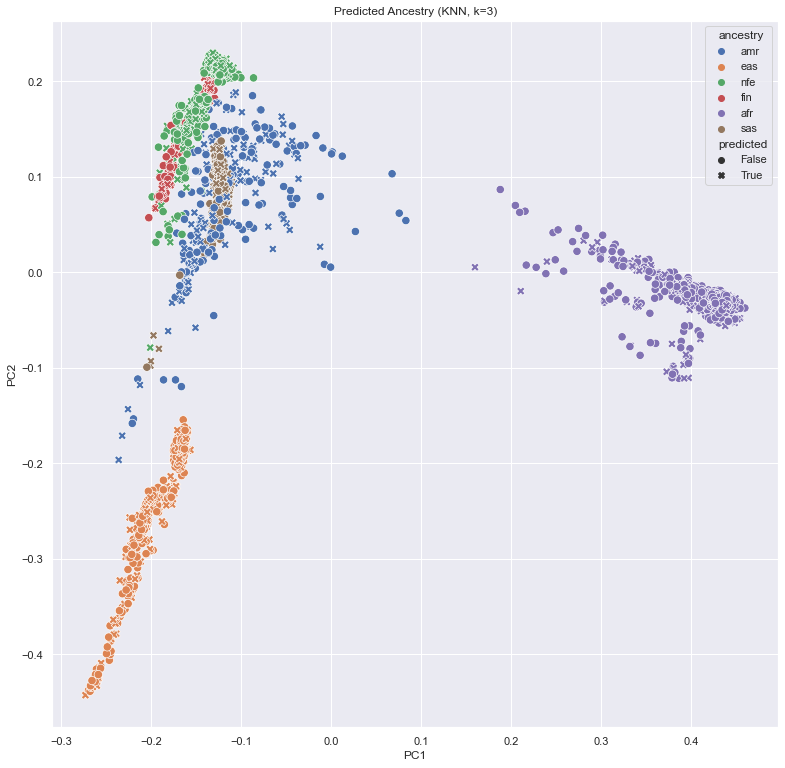

In [14]:
# scatterplot of PCA values of known/predicted sample ancestry labels
sns.set(rc={'figure.figsize':(13,13)})
anc_plot = sns.scatterplot(data=final_df, x='PC1', y='PC2', 
                           hue='ancestry', style='predicted',
                           s=70).set(title='Predicted Ancestry (KNN, k=3)',)
anc_plot

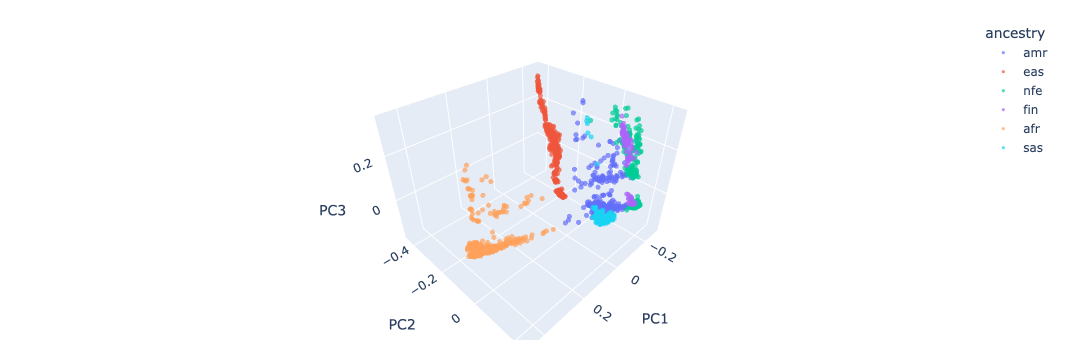

In [32]:
# 3D scatterplot
import plotly.express as px
fig = px.scatter_3d(final_df, x=final_df['PC1'], y=final_df['PC2'], z=final_df['PC3'],
                    color=final_df['ancestry'], opacity=0.7, size_max=1)
fig.update_layout(margin=dict(l=100, r=100, t=20, b=20))
fig.update_traces(marker=dict(size=3))
fig.show()